<a href="https://colab.research.google.com/github/andres-eric/PYSPARK_clasificacion_pacientes-de-hospital-de-Envigado/blob/main/PYSPARK_clasificacion_pacientes_de_hospital_de_Envigado.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **LIBRERIAS Y INSTALACION DE PAQUERES**

In [ ]:
!wget --no-cache -O init.py -q https://raw.githubusercontent.com/UDEA-Esp-Analitica-y-Ciencia-de-Datos/EACD-03-BIGDATA/master/init.py
import init; init.init(force_download=False);
from IPython.display import Image

replicating local resources


In [ ]:
#Instalación
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!wget -q http://archive.apache.org/dist/spark/spark-3.0.1/spark-3.0.1-bin-hadoop3.2.tgz
!tar xf spark-3.0.1-bin-hadoop3.2.tgz
!pip install -q findspark

#Variables de Entorno
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.1-bin-hadoop3.2"

#SparkContext
import findspark
findspark.init()
from pyspark.sql import SparkSession
from pyspark import SparkContext
spark = SparkSession.builder.master("local[*]").getOrCreate()
sc = SparkContext.getOrCreate()

In [ ]:

#SQL Context
from pyspark.sql import SQLContext
from pyspark.sql import functions
from pyspark.sql.types import *
sqlCtx = SQLContext(sc)

from pyspark.sql import Row
from pyspark.sql import SparkSession
from pyspark.sql.types import * # Import all types

from pyspark.sql.functions import udf
from pyspark.sql.types import StringType

from pyspark.sql.functions import udf, col # Ensure 'col' is imported correctly
from pyspark.sql.types import StringType

In [ ]:
spark = SparkSession.builder \
    .appName("PandasToPySpark") \
    .getOrCreate()


In [ ]:
import requests # Import the requests library into your environment
import tempfile # Import the tempfile module to create temporary files

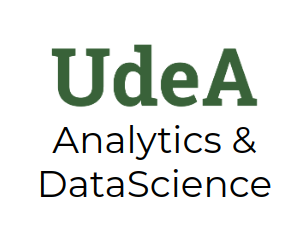

In [ ]:
Image("local/imgs/udea-datascience.png")

### **DESCARGA DEL DATA SET**

In [ ]:
url = "https://www.datos.gov.co/api/views/4ike-xz34/rows.csv?accessType=DOWNLOAD"

response = requests.get(url)
response.raise_for_status()


with tempfile.NamedTemporaryFile(delete=False, suffix='.csv') as temp_file:
      temp_file.write(response.content)
      temp_path = temp_file.name

df = spark.read.option("header", "true") \
                   .option("inferSchema", "true") \
                   .csv(temp_path)

### **Análisis de pacientes de hospital de Envigado**

El archivo poblacion_atendida.csv contiene información sobre los pacientes atendidos en un Hospital en Envigado. Para cada paciente se tiene la siguiente información:

* SEXO
* ESTADO_CIVIL
* ZONA_RES
* MUN_RES
* PAIS_NCTO
* EDAD
* ESCOLARIDAD_PACIENTE

Fuente de los datos: https://www.datos.gov.co/Salud-y-Protecci-n-Social/Poblaci-n-Atendida-a-o-2020/4ike-xz34


Se solicita de su ayuda para realizar las siguientes actividades:

##**A) Preparación de datos**

Se revisa cada una de las variables disponibles y se realiza la respectiva prepración de datos antes de proceder a crear los modelos de Machine Learning


### **IDENTIFICAR VARIABLES**

In [ ]:
df.printSchema()
df.show(5)

root
 |-- SEXO: string (nullable = true)
 |-- ESTADO_CIVIL: string (nullable = true)
 |-- ZONA_RES: string (nullable = true)
 |-- MUN_RES: string (nullable = true)
 |-- EDAD: integer (nullable = true)
 |-- ESCOLARIDAD_PACIENTE: string (nullable = true)
 |-- GRUPO_EDAD: string (nullable = true)
 |-- TIPO_PACNAL: string (nullable = true)
 |-- DISCAPACIDAD: string (nullable = true)
 |-- VICTIMA_CA: string (nullable = true)
 |-- FECHA DE LA CARACTERIZACIÓN: string (nullable = true)
 |-- GRUPO POBLACIONAL: string (nullable = true)
 |-- DATOS DE LA ASEGURADORA (EAPB): string (nullable = true)

+---------+--------------------+--------+--------+----+--------------------+----------------+-----------+---------------+---------------+---------------------------+-----------------+------------------------------+
|     SEXO|        ESTADO_CIVIL|ZONA_RES| MUN_RES|EDAD|ESCOLARIDAD_PACIENTE|      GRUPO_EDAD|TIPO_PACNAL|   DISCAPACIDAD|     VICTIMA_CA|FECHA DE LA CARACTERIZACIÓN|GRUPO POBLACIONAL|DATOS D

### **TRTAMIENTO DE DUPLICADOS**

**borrar duplicados**

In [ ]:
total_registros = df.count()
print('Total de registros del data set: ', total_registros)

Total de registros del data set:  93356


In [ ]:
df_ = df.dropDuplicates()
print('Total de registros sin duplicados del data set: ', df_.count())

Total de registros sin duplicados del data set:  91967


**variables irrelevantes**



Para lograr el objetivo segmentación de pacientes mediante KMeans es importante identificar las variables relevantes y excluir las variables que posiblemente no impacten el modelo ya que no aporta información directa sobre el paciente para la segmentación

- FECHA DE LA CARACTERIZACIÓN
- DATOS DE LA ASEGURADORA: Contiene información administrativa que probablemente no sea útil para la segmentación
- VARIABLE REDUNDANTE: GRUPO_EDAD, no es necesario incluir EDAD directamente, ya que GRUPO_EDAD agrupa las edad de forma categórica con un rango de 4 años por rango por lo que tendria al menos 20 caterias de edad

In [ ]:
df_=df_.drop('GRUPO_EDAD','FECHA DE LA CARACTERIZACIÓN')

### **VALORES NULLOS**



In [ ]:
for col in  df_.columns:
  print(col,df.filter(df[col].isNull()).count())

SEXO 0
ESTADO_CIVIL 0
ZONA_RES 0
MUN_RES 0
EDAD 0
ESCOLARIDAD_PACIENTE 0
TIPO_PACNAL 0
DISCAPACIDAD 0
VICTIMA_CA 0
GRUPO POBLACIONAL 0
DATOS DE LA ASEGURADORA (EAPB) 0


Presente aquí el código desarrollado y el resultado obtenido

### **ANALISIS UNIVARIADO**

**analisis de categoria por variable**

In [ ]:
for col in  df_.columns:
  print(col,df_.select(col).distinct().count())

SEXO 2
ESTADO_CIVIL 6
ZONA_RES 3
MUN_RES 352
EDAD 106
ESCOLARIDAD_PACIENTE 14
TIPO_PACNAL 3
DISCAPACIDAD 2
VICTIMA_CA 2
GRUPO POBLACIONAL 7
DATOS DE LA ASEGURADORA (EAPB) 81


Las variables como SEXO, ZONA_RES, TIPO_PACNAL, DISCAPACIDAD, y VICTIMA_CA, tienen categorías limitadas. por otro lado variables como EDAD, MUN_RES , DATOS DE LA ASEGURADORA  requiere ser agrupada en rangos o categorias con el fin de hebitar el detalle inecesario  o verificar la importancia de variables como MUN_RES y DE LA ASEGURADORA ya que contiene alta dimensionalidad.

**Variables numéricas**

In [ ]:
df_.select('EDAD').describe().show()

+-------+------------------+
|summary|              EDAD|
+-------+------------------+
|  count|             91967|
|   mean|42.204660367305664|
| stddev|23.760919148074922|
|    min|                 0|
|    max|               111|
+-------+------------------+



**Variables categóricas**

In [ ]:
df_.groupBy('SEXO').count().show()

+---------+-----+
|     SEXO|count|
+---------+-----+
| FEMENINO|54295|
|MASCULINO|37672|
+---------+-----+



El conteo muestra que hay más registros femeninos 54,295 que masculinos 37,672.

1.   Elemento de lista
2.   Elemento de lista

Esto muestra un desbalance entre las categorías. tambien es importante cuestionar si esta variable aporta valor al clostering

In [ ]:
df_.groupBy('ESTADO_CIVIL').count().show(truncate=False)

+---------------------------+-----+
|ESTADO_CIVIL               |count|
+---------------------------+-----+
|VIUDO                      |4701 |
|SOLTERO                    |34168|
|DIVORCIADO O SEPARADO      |2881 |
|SIN INFORMACION O NO APLICA|18591|
|CASADO                     |19979|
|UNION LIBRE                |11647|
+---------------------------+-----+



Algunas categorías, como "Viudo" y "Divorciado o Separado", tienen pocas observaciones, lo que puede hacerlas menos útiles para el modelo y aumentar el ruido.

se puede pensar en agrupar categorías con pocos casos en una genérica, como "Otros"

La categoría "Sin información o no aplica" representa una proporción considerable y necesita un manejo especial, ya que podría ser información faltante o irrelevante.

In [ ]:
df_.groupBy('TIPO_PACNAL').count().show()


+---------------+-----+
|    TIPO_PACNAL|count|
+---------------+-----+
|SIN INFORMACIÓN|  235|
|    EXTRANJEROS| 3643|
|     NACIONALES|88089|
+---------------+-----+



Los datos muestran una fuerte mayoria en pacientes nacionales en comparación con extranjeros

la mayor representatividad se encuentra en los nacionales  más del 95% del total por lo que es una opcion enfocarse en el grupo de nacionales

In [ ]:
df_.groupBy('DISCAPACIDAD').count().show()


+---------------+-----+
|   DISCAPACIDAD|count|
+---------------+-----+
|SIN INFORMACIÓN|91760|
|             SI|  207|
+---------------+-----+



Los datos presentan una clara mayoría de registros clasificados como "SIN INFORMACIÓN", La cantidad de casos con si es muy baja lo que no proporciona suficiente representatividad para que el modelo aprenda patrones relacionados con esta categoría. excluir esta variable sería una opcion válida

In [ ]:

df_.groupBy('VICTIMA_CA').count().show()


+---------------+-----+
|     VICTIMA_CA|count|
+---------------+-----+
|SIN INFORMACIÓN|91903|
|             SI|   64|
+---------------+-----+



asi mismo la variable VICTIMA_CA puede ser excluida sin afectar significativamente el desempeño del modelo, ya que su baja variabilidad y representatividad limitan su utilidad para el análisis

In [ ]:
df_.groupBy('GRUPO POBLACIONAL').count().show(truncate=False)

+----------------------------------------------------+-----+
|GRUPO POBLACIONAL                                   |count|
+----------------------------------------------------+-----+
|Población indígena                                  |65   |
|Población víctima del conflicto armado              |63   |
|Sin Información                                     |91214|
|Población afrocolombiana, negra, palenquera y raizal|392  |
|Población ROM o gitana                              |9    |
|Población en situación de discapacidad              |207  |
|Población LGBTIQ+                                   |17   |
+----------------------------------------------------+-----+




La mayoría de los registros 99% están etiquetados como "Sin Información", lo que dificulta extraer valor informativo de esta variable.

Dado el predominio absoluto de la categoría "Sin Información", y la baja representatividad de las demás categorías, podría considerarce excluir esta variable

In [ ]:
df_.groupBy('ZONA_RES').count().show()

+---------------+-----+
|       ZONA_RES|count|
+---------------+-----+
|SIN INFORMACIÓN|   25|
|          RURAL|  464|
|         URBANA|91478|
+---------------+-----+



La categoría "URBANA" domina  los datos, con 91,478 registros, lo que La variable tiene un desbalance importante entre las categorías "URBANA" y "RURAL". Aunque esto puede reflejar la realidad de la población estudiada, es importante analizar si la baja representación de "RURAL"representa.  

Mantener la variable ZONA_RES: Puede ser útil para identificar patrones en la segmentación, ya que refleja un aspecto demográfico relevante, tambien seria relevante filtrar el data set por la caracteristica URBANA

In [ ]:
df_.groupBy('ESCOLARIDAD_PACIENTE').count().show()

+--------------------+-----+
|ESCOLARIDAD_PACIENTE|count|
+--------------------+-----+
|          Preescolar| 2304|
|   Basica Secundaria|25718|
|             Ninguno|22611|
|            Primaria|    5|
|     Basica Primaria|20618|
|Media Tecnica (Ba...|  410|
|         Tecnologica| 2735|
|           Doctorado|   85|
|          Normalista|  215|
|Media Academica o...| 4434|
|     Especializacion| 1240|
| Tecnica Profesional| 4103|
|            Maestria|  159|
|         Profesional| 7330|
+--------------------+-----+




Esta variable puede ser relevante para la segmentación, ya que el nivel educativo podría estar relacionado con patrones de atención o necesidades específicas de los pacientes.

Agrupar de categorías Reducir el número de categorías al agruparlas en niveles educativos más amplios.

conclucion

**filtrar data set**

In [ ]:
df_ml=df_.select('SEXO','ESTADO_CIVIL','ZONA_RES','EDAD','ESCOLARIDAD_PACIENTE','TIPO_PACNAL')

### **TRATAMIENTO  CATEGORIAS DATAFRAME**

**funcion agrupar estado civil**

In [ ]:
def estado(x):
  if x in ['CASADO','UNION LIBRE']:
    return 'Con pareja'
  elif x in ['SOLTERO','DIVORCIADO','VIUDO','SEPARADO']:
    return 'Sin pareja'
  else:
    return 'Sin información'

In [ ]:
estado_udf = udf(estado, StringType())

In [ ]:
from pyspark.sql.functions import udf, col
from pyspark.sql.types import StringType

In [ ]:
df_ml_ = df_ml.withColumn("ESTADO_CIVIL_", estado_udf(col("ESTADO_CIVIL")))

In [ ]:
df_ml_ = df_ml_.drop('ESTADO_CIVIL')

**funcion agrupar ESCOLARIDAD_PACIENTE**

In [ ]:
def educacion(x):
    if x in ['Ninguno', 'Preescolar']:
        return 'Sin escolaridad'
    elif x in ['Basica Primaria', 'Primaria', 'Basica Secundaria']:
        return 'Educacion Basica'
    elif x in ['Media Academica o Clasica', 'Media Tecnica (Bachillerato T)', 'Normalista','Tecnica Profesional', 'Tecnologica']:
        return 'Educacion Media'
    elif x in ['Profesional']:
        return 'Educacion Superior'
    elif x in ['Especializacion', 'Maestria', 'Doctorado']:
        return 'Posgrado'
    else:
        return 'Otra'




In [ ]:
educacion_udf = udf(educacion, StringType())

In [ ]:
df_ml_ = df_ml_.withColumn("educacion", educacion_udf(col("ESCOLARIDAD_PACIENTE")))

In [ ]:
df_ml_ = df_ml_.drop('ESCOLARIDAD_PACIENTE')

**funcion agrupar EDAD**

In [ ]:
from pyspark.sql.functions import col, max
max_edad = df_ml_.select(max(col("EDAD")).alias("max_EDAD")).collect()[0]["max_EDAD"]

In [ ]:
def edad(x):
    if x < 18:
        return 'Jovenes'
    elif 18 <= x <= 60:
        return 'Adultos'
    elif x > 60:
        return 'Mayores'
    else:
        return 'Otra'



In [ ]:
edad_udf = udf(edad, StringType())

In [ ]:
df_ml_ = df_ml_.withColumn("edad", edad_udf(col("EDAD")))

In [ ]:
edad_udf = udf(edad, StringType())

### **REGISTRAR DATA SET COMO CONSULTA SQL**

In [ ]:
df_ml_.createOrReplaceTempView("mi_tabla_sql")

In [ ]:
result = spark.sql("SELECT * FROM mi_tabla_sql")

In [ ]:
result.show()

+---------+--------+-------+-----------+---------------+----------------+
|     SEXO|ZONA_RES|   edad|TIPO_PACNAL|  ESTADO_CIVIL_|       educacion|
+---------+--------+-------+-----------+---------------+----------------+
|MASCULINO|  URBANA|Adultos| NACIONALES|     Con pareja|Educacion Basica|
|MASCULINO|  URBANA|Mayores| NACIONALES|     Con pareja|Educacion Basica|
| FEMENINO|  URBANA|Jovenes| NACIONALES|Sin información| Sin escolaridad|
|MASCULINO|  URBANA|Adultos| NACIONALES|     Con pareja|Educacion Basica|
|MASCULINO|  URBANA|Mayores| NACIONALES|     Con pareja|Educacion Basica|
| FEMENINO|  URBANA|Mayores| NACIONALES|     Sin pareja|Educacion Basica|
| FEMENINO|  URBANA|Adultos| NACIONALES|     Con pareja| Educacion Media|
| FEMENINO|  URBANA|Adultos| NACIONALES|     Con pareja|Educacion Basica|
| FEMENINO|  URBANA|Adultos| NACIONALES|     Con pareja|Educacion Basica|
|MASCULINO|  URBANA|Adultos| NACIONALES|     Con pareja|Educacion Basica|
|MASCULINO|  URBANA|Adultos| NACIONALE

In [ ]:
for col in  df_ml_.columns:
  print(col,df_ml_.select(col).distinct().count())

SEXO 2
ZONA_RES 3
edad 3
TIPO_PACNAL 3
ESTADO_CIVIL_ 3
educacion 5


In [ ]:
result.registerTempTable("df_result") #This line is changed to use the 'result' DataFrame instead of 'result_', which is not defined in the original code.
df_result=spark.sql("""SELECT

--SEXO
edad
,ESTADO_CIVIL_
,educacion

FROM mi_tabla_sql  WHERE TIPO_PACNAL='NACIONALES' AND ZONA_RES='URBANA' AND ESTADO_CIVIL_!='Sin información' """)

**funciones categoricas a numericas**

In [ ]:
def sexo_numm(x):
  if x=='MASCULINO':
    return 1
  else:
    return 0

def edad(x):
  if x=='Jovenes':
    return 1
  elif x=='Adultos':
    return 2
  elif x=='Mayores':
    return 3
  elif x=='Otra':
    return 4

def estado_civil(x):
  if x=='Con pareja':
    return 1
  if x=='Sin pareja':
    return 2
  else:
    return 0

def educacion(x):
  if x=='Sin escolaridad':
    return 1
  elif x=='Educacion Basica':
    return 2
  elif x=='Educacion Media':
    return 3
  elif x=='Educacion Superior':
    return 4
  elif x=='Posgrado':
    return 5
  else:
    return 0


In [ ]:
sqlCtx.registerFunction("sexo_numm",sexo_numm)
sqlCtx.registerFunction("edad",edad)
sqlCtx.registerFunction("estado_civil",estado_civil)
sqlCtx.registerFunction("educacion",educacion)

<function __main__.educacion(x)>

In [ ]:
df_modelo_=sqlCtx.sql("""
		SELECT

    *
    ---,sexo_numm(SEXO) AS sexo_Int
    ,edad(edad) AS edad_Int
    ,estado_civil(ESTADO_CIVIL_) AS estado_civil_Int
    ,educacion(educacion) AS educacion_Int

		FROM df_result
		""")

In [ ]:
df_evaluar=df_modelo_.select('edad','ESTADO_CIVIL_','educacion')

In [ ]:
df_modelo_.show()

+---------+--------+-------+-----------+---------------+----------------+--------+----------------+-------------+
|     SEXO|ZONA_RES|   edad|TIPO_PACNAL|  ESTADO_CIVIL_|       educacion|edad_Int|estado_civil_Int|educacion_Int|
+---------+--------+-------+-----------+---------------+----------------+--------+----------------+-------------+
|MASCULINO|  URBANA|Adultos| NACIONALES|     Con pareja|Educacion Basica|       2|               1|            2|
|MASCULINO|  URBANA|Mayores| NACIONALES|     Con pareja|Educacion Basica|       3|               1|            2|
| FEMENINO|  URBANA|Jovenes| NACIONALES|Sin información| Sin escolaridad|       1|               0|            1|
|MASCULINO|  URBANA|Adultos| NACIONALES|     Con pareja|Educacion Basica|       2|               1|            2|
|MASCULINO|  URBANA|Mayores| NACIONALES|     Con pareja|Educacion Basica|       3|               1|            2|
| FEMENINO|  URBANA|Mayores| NACIONALES|     Sin pareja|Educacion Basica|       3|      

preparamos el data set para aplicar la vectorizacion

In [ ]:
df_modelo_ = df_modelo_.drop("SEXO", "edad", "ESTADO_CIVIL_", "educacion","ZONA_RES","TIPO_PACNAL")

In [ ]:
#df_modelo_ = df_modelo_.withColumn("sexo_Int", df_modelo_["sexo_Int"].cast(IntegerType()))
df_modelo_ = df_modelo_.withColumn("edad_Int", df_modelo_["edad_Int"].cast(IntegerType()))
df_modelo_ = df_modelo_.withColumn("estado_civil_Int", df_modelo_["estado_civil_Int"].cast(IntegerType()))
df_modelo_ = df_modelo_.withColumn("educacion_Int", df_modelo_["educacion_Int"].cast(IntegerType()))
data_=df_modelo_
data_.printSchema()

root
 |-- edad_Int: integer (nullable = true)
 |-- estado_civil_Int: integer (nullable = true)
 |-- educacion_Int: integer (nullable = true)



##**B) Análisis Descriptivo**

Se crea un modelo de Kmeans que permitan describir los tipos de pacientes del hospital

In [ ]:
from pyspark.ml.feature import VectorAssembler

In [ ]:
vectorAssembler = VectorAssembler(inputCols = data_.columns, outputCol = 'features', handleInvalid="skip")
vdata = vectorAssembler.transform(data_)
vdata.cache()


DataFrame[edad_Int: int, estado_civil_Int: int, educacion_Int: int, features: vector]

**calcular el numero de closter optimo para el k means**

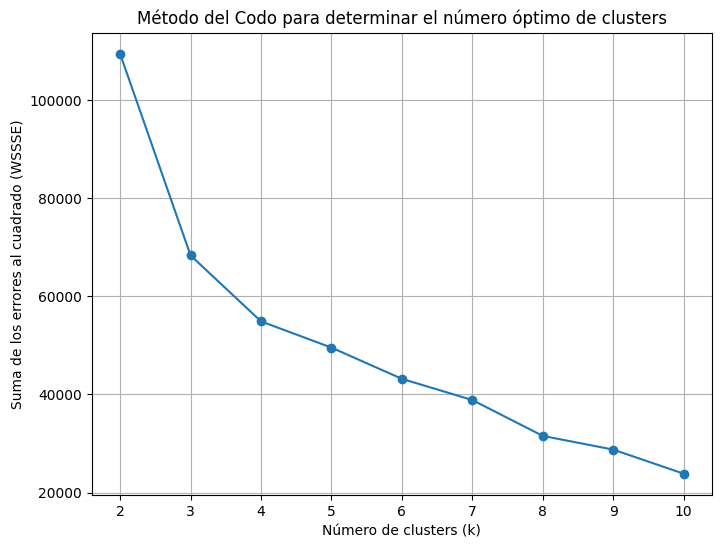

In [ ]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
import matplotlib.pyplot as plt


wssse_list = []

k_values = range(2, 11)

for k in k_values:

    km = KMeans(featuresCol='features', k=k, predictionCol='cluster', distanceMeasure='euclidean')
    km_model = km.fit(vdata)


    wssse = km_model.summary.trainingCost
    wssse_list.append(wssse)


plt.figure(figsize=(8, 6))
plt.plot(k_values, wssse_list, marker='o')
plt.title('Método del Codo para determinar el número óptimo de clusters')
plt.xlabel('Número de clusters (k)')
plt.ylabel('Suma de los errores al cuadrado (WSSSE)')
plt.grid()
plt.show()

Al analizar la gráfica del método del codo se observa que seleccionar k=5 podría ser un buen punto para balancear simplicidad y rendimiento del modelo. Sin embargo también se puede considerar k = 6,

**se aplica modelo k mean closter= 6**

In [ ]:
#from pyspark.ml.clustering import KMeans
#km = KMeans( featuresCol='features', k=3, predictionCol='cluster', distanceMeasure='euclidean')
#km_model = km.fit(vdata)

In [ ]:
#predictions = km_model.transform(vdata)
#predictions.show()

In [ ]:
from pyspark.ml.feature import StandardScaler
from pyspark.ml.clustering import KMeans

# Escalar las características
scaler = StandardScaler(inputCol='features', outputCol='scaled_features', withStd=True, withMean=False)
scaled_data = scaler.fit(vdata).transform(vdata)

# Crear el modelo KMeans utilizando las características escaladas
km = KMeans(featuresCol='scaled_features', k=4, predictionCol='cluster', distanceMeasure='euclidean')
km_model = km.fit(scaled_data)

# Realizar las predicciones
predictions = km_model.transform(scaled_data)

# Mostrar las predicciones
#predictions.show()


**se une la prediccion de closter con el data set original**

In [ ]:
from pyspark.sql.functions import monotonically_increasing_id

In [ ]:
df_result_1 = df_evaluar.withColumn("row_id", monotonically_increasing_id())
predictions = predictions.withColumn("row_id", monotonically_increasing_id())

In [ ]:
df_resultado = df_result_1.join(predictions.select("row_id", "cluster"), on="row_id", how="inner")


df_resultado = df_resultado.drop("row_id")

**se crea columna de caracteristicas para analizar o observar las particularidades de cada closter**

In [ ]:
from pyspark.sql.functions import concat_ws

In [ ]:
df_resultado = df_resultado.withColumn( "caracteristicas", concat_ws(", ", "edad", "ESTADO_CIVIL_", "educacion"))

In [ ]:
df_resultado.select('edad','ESTADO_CIVIL_','educacion','cluster').filter(df_resultado.cluster==0).show(20,truncate=False)

+-------+---------------+----------------+-------+
|edad   |ESTADO_CIVIL_  |educacion       |cluster|
+-------+---------------+----------------+-------+
|Mayores|Con pareja     |Educacion Basica|0      |
|Mayores|Con pareja     |Educacion Basica|0      |
|Mayores|Sin pareja     |Educacion Basica|0      |
|Mayores|Sin pareja     |Educacion Basica|0      |
|Mayores|Sin pareja     |Educacion Basica|0      |
|Mayores|Con pareja     |Educacion Basica|0      |
|Mayores|Sin pareja     |Educacion Basica|0      |
|Mayores|Con pareja     |Educacion Basica|0      |
|Mayores|Sin pareja     |Educacion Basica|0      |
|Mayores|Con pareja     |Educacion Basica|0      |
|Mayores|Sin pareja     |Educacion Basica|0      |
|Mayores|Sin pareja     |Educacion Media |0      |
|Mayores|Sin pareja     |Educacion Basica|0      |
|Mayores|Sin información|Sin escolaridad |0      |
|Mayores|Sin información|Educacion Basica|0      |
|Mayores|Sin pareja     |Educacion Basica|0      |
|Mayores|Con pareja     |Educac

Edad: Los adultos mayores o jóvenes pueden estar en diferentes niveles de riesgo según la condición estudiada.
Estado Civil: Las personas sin pareja pueden tener menor apoyo en el manejo de su salud, lo que podría aumentar el riesgo.
Nivel Educativo: Menor educación podría asociarse con menor acceso o comprensión de los sistemas de salud.

Pacientes con "Sin escolaridad" y "Sin pareja" podrían ser clasificados como "Alta necesidad de apoyo."

In [ ]:
df_resultado.select('edad','ESTADO_CIVIL_','educacion','cluster').filter(df_resultado.cluster==1).show(20,truncate=False)

+-------+-------------+----------------+-------+
|edad   |ESTADO_CIVIL_|educacion       |cluster|
+-------+-------------+----------------+-------+
|Adultos|Con pareja   |Educacion Basica|1      |
|Adultos|Con pareja   |Educacion Basica|1      |
|Adultos|Con pareja   |Educacion Basica|1      |
|Adultos|Con pareja   |Educacion Basica|1      |
|Adultos|Con pareja   |Educacion Basica|1      |
|Adultos|Con pareja   |Educacion Basica|1      |
|Adultos|Sin pareja   |Educacion Basica|1      |
|Adultos|Sin pareja   |Educacion Media |1      |
|Adultos|Con pareja   |Educacion Basica|1      |
|Adultos|Con pareja   |Educacion Basica|1      |
|Adultos|Sin pareja   |Educacion Basica|1      |
|Adultos|Sin pareja   |Sin escolaridad |1      |
|Adultos|Sin pareja   |Educacion Basica|1      |
|Adultos|Sin pareja   |Educacion Media |1      |
|Adultos|Sin pareja   |Educacion Basica|1      |
|Adultos|Sin pareja   |Educacion Basica|1      |
|Adultos|Sin pareja   |Educacion Basica|1      |
|Adultos|Con pareja 

La mayoría de los pacientes caen en esta categoría. Son adultos con pareja y educación básica, lo que indica una estabilidad relativa en términos de soporte social y acceso educativo.

Los adultos dominan la muestra, lo que podría sugerir que este grupo tiene mayor representación en la población atendida, se puede considerar "Necesidad moderada de apoyo"

In [ ]:
df_resultado.select('edad','ESTADO_CIVIL_','educacion','cluster').filter(df_resultado.cluster==2).show(20,truncate=False)

+-------+---------------+----------------+-------+
|edad   |ESTADO_CIVIL_  |educacion       |cluster|
+-------+---------------+----------------+-------+
|Jovenes|Sin información|Sin escolaridad |2      |
|Jovenes|Sin información|Sin escolaridad |2      |
|Jovenes|Sin información|Sin escolaridad |2      |
|Jovenes|Con pareja     |Educacion Basica|2      |
|Jovenes|Sin información|Sin escolaridad |2      |
|Jovenes|Sin información|Sin escolaridad |2      |
|Adultos|Sin información|Sin escolaridad |2      |
|Adultos|Sin información|Educacion Basica|2      |
|Jovenes|Sin información|Sin escolaridad |2      |
|Adultos|Sin información|Educacion Basica|2      |
|Adultos|Sin información|Sin escolaridad |2      |
|Adultos|Sin información|Educacion Basica|2      |
|Jovenes|Sin información|Sin escolaridad |2      |
|Jovenes|Sin información|Sin escolaridad |2      |
|Jovenes|Sin información|Sin escolaridad |2      |
|Jovenes|Sin información|Sin escolaridad |2      |
|Jovenes|Sin información|Sin es

La combinación de "Sin escolaridad" y "Sin información" crea incertidumbre sobre el soporte social, incrementando la vulnerabilidad, en una etapa formativa sin acceso a educación ni claridad sobre su soporte social, lo que los hace extremadamente vulnerables, se clasifica como "Alta necesidad de apoyo"

In [ ]:
df_resultado.select('edad','ESTADO_CIVIL_','educacion','cluster').filter(df_resultado.cluster==3).show(20,truncate=False)

+-------+-------------+------------------+-------+
|edad   |ESTADO_CIVIL_|educacion         |cluster|
+-------+-------------+------------------+-------+
|Adultos|Con pareja   |Educacion Media   |3      |
|Adultos|Con pareja   |Educacion Media   |3      |
|Adultos|Con pareja   |Educacion Media   |3      |
|Adultos|Con pareja   |Educacion Media   |3      |
|Adultos|Sin pareja   |Educacion Superior|3      |
|Adultos|Con pareja   |Educacion Media   |3      |
|Adultos|Con pareja   |Posgrado          |3      |
|Adultos|Sin pareja   |Educacion Superior|3      |
|Adultos|Sin pareja   |Educacion Superior|3      |
|Adultos|Con pareja   |Educacion Media   |3      |
|Adultos|Con pareja   |Posgrado          |3      |
|Adultos|Sin pareja   |Educacion Superior|3      |
|Adultos|Con pareja   |Educacion Media   |3      |
|Adultos|Con pareja   |Educacion Media   |3      |
|Adultos|Con pareja   |Educacion Media   |3      |
|Adultos|Sin pareja   |Educacion Superior|3      |
|Adultos|Sin pareja   |Educacio

La mayoría tiene Educación Media.
Un grupo significativo tiene Educación Superior.
Un grupo más pequeño tiene Posgrado.

El Clúster 3 representa una población adulta con niveles educativos que van desde media hasta posgrado. Las diferencias en estado civil y nivel educativo permiten segmentar el grupo en niveles de necesidad. La mayoría tiene necesidad moderada de apoyo,

##**C) Análisis Predictivo**

Usando el clúster asignado a cada paciente como variable objetivo, Se crea un modelo predictivo que permita predecir el grupo al que pertenece cada paciente

**preparar data**

In [ ]:
df_resultado.createOrReplaceTempView("df_modelo_pred")

In [ ]:
df_modelo_pred=sqlCtx.sql("""
		SELECT

    *
    ---,sexo_numm(SEXO) AS sexo_Int
    ,edad(edad) AS edad_Int
    ,estado_civil(ESTADO_CIVIL_) AS estado_civil_Int
    ,educacion(educacion) AS educacion_Int

		FROM df_modelo_pred
		""")

In [ ]:
df_modelo_pred = df_modelo_pred.drop("SEXO", "edad", "ESTADO_CIVIL_", "educacion","ZONA_RES","TIPO_PACNAL",'caracteristicas')

se transforman numericas las variables

In [ ]:

df_modelo_pred = df_modelo_pred.withColumn("cluster", df_modelo_pred["cluster"].cast(IntegerType()))
df_modelo_pred = df_modelo_pred.withColumn("edad_Int", df_modelo_pred["edad_Int"].cast(IntegerType()))
df_modelo_pred = df_modelo_pred.withColumn("estado_civil_Int", df_modelo_pred["estado_civil_Int"].cast(IntegerType()))
df_modelo_pred = df_modelo_pred.withColumn("educacion_Int", df_modelo_pred["educacion_Int"].cast(IntegerType()))

In [ ]:
df_modelo_pred.show()

+-------+--------+----------------+-------------+
|cluster|edad_Int|estado_civil_Int|educacion_Int|
+-------+--------+----------------+-------------+
|      1|       2|               1|            2|
|      0|       3|               1|            2|
|      2|       1|               0|            1|
|      1|       2|               1|            2|
|      0|       3|               1|            2|
|      0|       3|               2|            2|
|      3|       2|               1|            3|
|      1|       2|               1|            2|
|      1|       2|               1|            2|
|      1|       2|               1|            2|
|      1|       2|               1|            2|
|      1|       2|               2|            2|
|      2|       1|               0|            1|
|      2|       1|               0|            1|
|      2|       1|               1|            2|
|      1|       2|               2|            3|
|      3|       2|               1|            3|


In [ ]:
vectorAssembler = VectorAssembler(inputCols = \
    ['edad_Int','estado_civil_Int','educacion_Int'], outputCol = 'features')
vest = vectorAssembler.transform(df_modelo_pred)
vest = vest.select(['features', 'cluster'])
vest.show(5)

+-------------+-------+
|     features|cluster|
+-------------+-------+
|[2.0,1.0,2.0]|      1|
|[3.0,1.0,2.0]|      0|
|[1.0,0.0,1.0]|      2|
|[2.0,1.0,2.0]|      1|
|[3.0,1.0,2.0]|      0|
+-------------+-------+
only showing top 5 rows



**Creamos los conjuntos de datos de entrenamiento y evaluación (Split)**

In [ ]:
(trainingData, testData) = vest.randomSplit([0.7, 0.3])
print(trainingData.count())
print(testData.count())

64218
27749


**Modelar hacer prediccion de clasificacion con el modelo logisticregression**

In [ ]:

from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression(labelCol="cluster", featuresCol="features",maxIter=10)
lr_model=lr.fit(trainingData)


In [ ]:

trainingSummary = lr_model.summary

**prediccion training**

In [ ]:
trainingSummary.predictions.select('cluster','prediction','probability').show(10)

+-------+----------+--------------------+
|cluster|prediction|         probability|
+-------+----------+--------------------+
|    2.0|       2.0|[0.00329695033328...|
|    2.0|       2.0|[0.00329695033328...|
|    2.0|       2.0|[0.00329695033328...|
|    2.0|       2.0|[0.00329695033328...|
|    2.0|       2.0|[0.00329695033328...|
|    2.0|       2.0|[0.00329695033328...|
|    2.0|       2.0|[0.00329695033328...|
|    2.0|       2.0|[0.00329695033328...|
|    2.0|       2.0|[0.00329695033328...|
|    2.0|       2.0|[0.00329695033328...|
+-------+----------+--------------------+
only showing top 10 rows



**evaluar**

In [ ]:

predict_test=lr_model.transform(testData)
predict_test.select('cluster','prediction','probability').show(10)

+-------+----------+--------------------+
|cluster|prediction|         probability|
+-------+----------+--------------------+
|      2|       2.0|[0.00329695033328...|
|      2|       2.0|[0.00329695033328...|
|      2|       2.0|[0.00329695033328...|
|      2|       2.0|[0.00329695033328...|
|      2|       2.0|[0.00329695033328...|
|      2|       2.0|[0.00329695033328...|
|      2|       2.0|[0.00329695033328...|
|      2|       2.0|[3.09043887239157...|
|      2|       2.0|[3.09043887239157...|
|      1|       1.0|[2.81032585464146...|
+-------+----------+--------------------+
only showing top 10 rows



**aca evaluamos el data set de testeo  con multples closter**

**acurracy**

In [ ]:

from pyspark.ml.evaluation import MulticlassClassificationEvaluator

evaluator = MulticlassClassificationEvaluator(labelCol='cluster', predictionCol='prediction', metricName='accuracy')
accuracy = evaluator.evaluate(predict_test)
print('Accuracy con los datos de evaluación:', accuracy)


Accuracy con los datos de evaluación: 0.9571516090669934


**f1_evaluator**

In [ ]:
f1_evaluator = MulticlassClassificationEvaluator(labelCol='cluster', predictionCol='prediction', metricName='f1')
f1_score = f1_evaluator.evaluate(predict_test)
print('F1-Score con los datos de evaluación:', f1_score)

F1-Score con los datos de evaluación: 0.9572440575797617


**matriz de confucion**

In [ ]:
predict_test.groupBy('cluster', 'prediction').count().sort('cluster', 'prediction').show()


+-------+----------+-----+
|cluster|prediction|count|
+-------+----------+-----+
|      0|       0.0| 6225|
|      0|       1.0|  190|
|      0|       2.0|  451|
|      1|       0.0|  339|
|      1|       1.0|11017|
|      2|       1.0|   38|
|      2|       2.0| 5350|
|      2|       3.0|    5|
|      3|       2.0|  166|
|      3|       3.0| 3968|
+-------+----------+-----+



Las combinaciones donde cluster es igual a prediction representan las predicciones correctas del modelo.

(cluster=0, prediction=0.0): 9207
(cluster=2, prediction=2.0): 3896
(cluster=1, prediction=1.0): 4102

cluster=1, prediction=3.0): 212 → El modelo predijo 3 para 212 observaciones que en realidad eran 1.
(cluster=0, prediction=3.0): 286 → El modelo predijo 3 para 286 observaciones que en realidad eran 0.
(cluster=3, prediction=3.0): 9825 → El modelo predijo correctamente muchas veces 3, pero este número podría sugerir un desequilibrio en las clases o un sesgo hacia predecir la clase 3

Presente aquí el código desarrollado y el resultado obtenido